In [56]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from rna_motif_library.settings import DATA_PATH
from rna_motif_library.util import add_motif_name_columns
from rna_motif_library.plotting import publication_style_ax

In [32]:
def add_residue_count(df: pd.DataFrame) -> pd.DataFrame:
    """Add a column counting non-gap residues in each sequence.

    Args:
        df: DataFrame containing motif data with 'msequence' column

    Returns:
        DataFrame with additional 'residue_num' column counting non-gap characters
    """
    df["residue_num"] = df["msequence"].str.replace("-", "").str.len()
    return df


def count_motifs_by_rmsd(df: pd.DataFrame, rmsd_cutoff) -> pd.DataFrame:
    """Count motifs grouped by sequence and RMSD cutoff.

    Args:
        df: DataFrame containing motif data with 'msequence', 'rmsd' and 'residue_num' columns
        rmsd_cutoff: Base RMSD threshold that will be multiplied by residue count

    Returns:
        DataFrame with counts per sequence and RMSD threshold
    """
    results = []
    for seq, group in df.groupby("msequence"):
        residue_count = group.iloc[0]["residue_num"]
        scaled_cutoff = rmsd_cutoff * residue_count
        results.append(
            {
                "msequence": seq,
                "mtype": group.iloc[0]["mtype"],
                f"rmsd_count": len(group[group["rmsd"] > scaled_cutoff]),
                "total_motifs": len(group),
            }
        )
    return pd.DataFrame(results)

In [46]:
df_aligned = pd.read_csv("../aligned_motifs.csv")
df_unique = pd.read_csv("../unique_motifs.csv")
print(len(df_unique))
df_unique = df_unique[df_unique["rmsd"].isna()]
df_unique["rmsd"] = 1000
df = pd.concat([df_aligned, df_unique])
df = add_motif_name_columns(df, "motif")
df = add_residue_count(df)

115264


In [43]:
print(len(df_unique))
print(len(df_aligned))

103954
788333


In [ ]:
def count_motifs_over_rmsd_range(df: pd.DataFrame) -> pd.DataFrame:
    """Count motifs for a range of RMSD cutoffs from 0 to 1.5 in 0.1 increments.

    Args:
        df: DataFrame containing motif data

    Returns:
        DataFrame with counts for each RMSD cutoff value and motif type
    """
    cutoffs = np.arange(0, 0.3, 0.02)
    results = []

    for cutoff in cutoffs:
        counts = count_motifs_by_rmsd(df, cutoff)
        total = counts["rmsd_count"].sum()

        # Get counts per motif type
        type_counts = counts.groupby("mtype")["rmsd_count"].sum()

        result = {"rmsd_cutoff": cutoff, "motif_count": total}
        # Add counts for each motif type
        for mtype in type_counts.index:
            result[f"{mtype}_count"] = type_counts[mtype]

        results.append(result)

    return pd.DataFrame(results)


# Generate counts across RMSD range
rmsd_range_counts = count_motifs_over_rmsd_range(df)
print("Motif counts across RMSD cutoffs:")
print(rmsd_range_counts)

Motif counts across RMSD cutoffs:
    rmsd_cutoff  motif_count  HAIRPIN_count  HELIX_count  NWAY_count  \
0          0.00       891543         146244       418683       68286   
1          0.02       694886         120945       330581       27453   
2          0.04       381929          64667       168739       13144   
3          0.06       249214          41984        98328       10264   
4          0.08       193305          32964        69110        9358   
5          0.10       163346          27738        54090        8994   
6          0.12       144732          24157        45063        8794   
7          0.14       132823          21674        39851        8696   
8          0.16       124948          19746        36830        8657   
9          0.18       119420          18226        34885        8625   
10         0.20       115263          17006        33635        8614   
11         0.22       113745          16544        33130        8613   
12         0.24       112689  

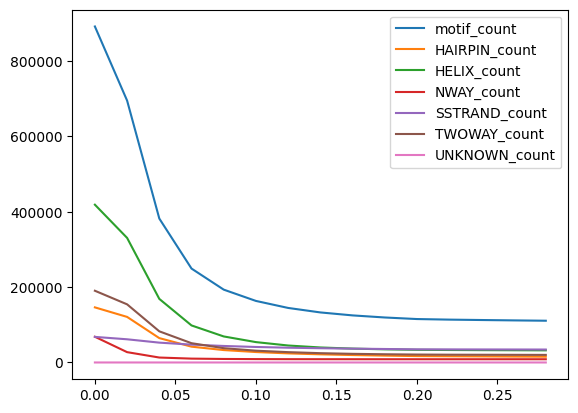

In [51]:
for mtype in rmsd_range_counts.columns[1:]:
    plt.plot(rmsd_range_counts["rmsd_cutoff"], rmsd_range_counts[mtype], label=mtype)
plt.legend()
plt.show()

In [47]:
# Example usage
rmsd_counts = count_motifs_by_rmsd(df, rmsd_cutoff=0.2)
print(rmsd_counts.head())
total = rmsd_counts["total_motifs"].sum()
rmsd_total = rmsd_counts["rmsd_count"].sum()
print(total, rmsd_total)

        msequence    mtype  rmsd_count  total_motifs
0               A  SSTRAND        3834          3834
1              AA  SSTRAND         288           765
2           AA-UU    HELIX         382          2523
3             AAA  SSTRAND         142           568
4  AAA-CAG-CAU-UG     NWAY           2             7
892287 115263


In [55]:
df_unique = pd.read_csv("../unique_motifs.csv")
df_unique = add_motif_name_columns(df_unique, "motif")
df_unique = df_unique.query("mtype != 'UNKNOWN'")

/var/folders/lg/b_1r07zd7174kpbyfysdr7p0dxd870/T/ipykernel_86000/4094376636.py:3: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")


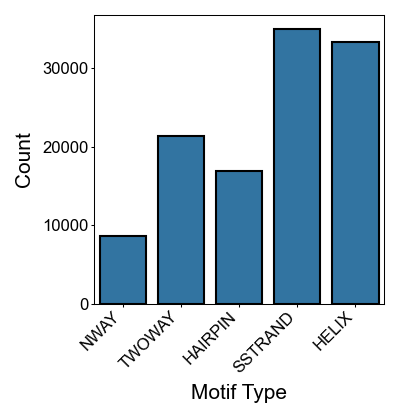

In [143]:
fig, ax = plt.subplots(figsize=(2.5, 2.5), dpi=150)
sns.countplot(x="mtype", data=df_unique, ax=ax, edgecolor="black")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
ax.set_xlabel("Motif Type")
ax.set_ylabel("Count")
publication_style_ax(ax)

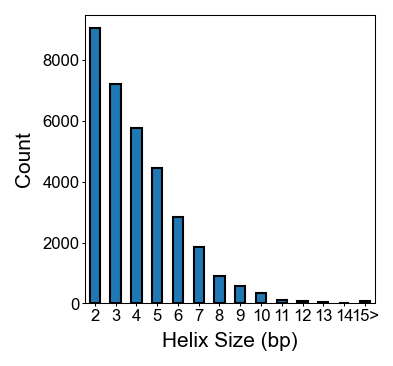

In [116]:
# Get helices and their sizes
helices = df_unique.query("mtype == 'HELIX'").copy()
helices["msize"] = helices["msize"].astype(int)
helix_sizes = helices["msize"].astype(int).value_counts()

# Group sizes > 14 into one category
grouped_sizes = helix_sizes.copy()
large_helices = grouped_sizes[grouped_sizes.index > 14].sum()
grouped_sizes = grouped_sizes[grouped_sizes.index <= 14]
grouped_sizes["15>"] = large_helices

# Create bar plot of helix sizes
fig, ax = plt.subplots(figsize=(2.5, 2.5), dpi=150)
grouped_sizes.plot(kind="bar", ax=ax, edgecolor="black")
ax.set_xlabel("Helix Size (bp)")
ax.set_xticklabels(ax.get_xticklabels(), rotation=0, ha="center")

ax.set_ylabel("Count")
publication_style_ax(ax)

In [95]:
helices = df_unique.query("mtype == 'HELIX'")
helices.sort_values(by="msize", ascending=False, inplace=True)

/var/folders/lg/b_1r07zd7174kpbyfysdr7p0dxd870/T/ipykernel_86000/1632803013.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  helices.sort_values(by="msize", ascending=False, inplace=True)


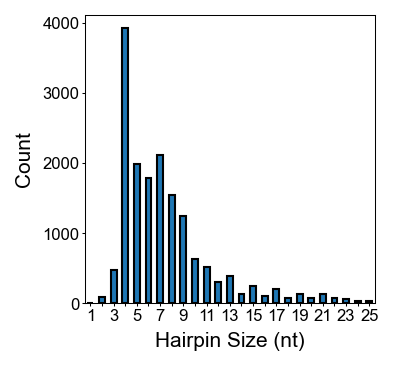

In [115]:
# Get hairpins and their sizes
hairpins = df_unique.query("mtype == 'HAIRPIN'").copy()
hairpins["msize"] = hairpins["msize"].astype(int)
hairpins = hairpins.query("msize <= 25")
hairpin_sizes = hairpins["msize"].astype(int).value_counts()

# Create bar plot of hairpin sizes
fig, ax = plt.subplots(figsize=(2.5, 2.5), dpi=150)
hairpin_sizes = hairpins["msize"].value_counts().sort_index()
hairpin_sizes.plot(kind="bar", ax=ax, edgecolor="black")
ax.set_xlabel("Hairpin Size (nt)")

# Label every other bar
labels = [str(x) if i % 2 == 0 else "" for i, x in enumerate(hairpin_sizes.index)]
ax.set_xticklabels(labels, rotation=0)

ax.set_ylabel("Count")
publication_style_ax(ax)

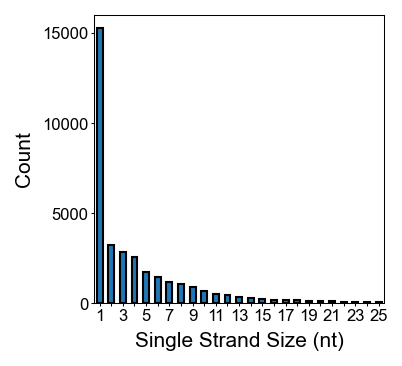

In [140]:
# Get single strands and their sizes
singles = df_unique.query("mtype == 'SSTRAND'").copy()
singles["msize"] = singles["msize"].astype(int)
singles = singles.query("msize <= 25")
single_sizes = singles["msize"].astype(int).value_counts()

# Create bar plot of single strand sizes
fig, ax = plt.subplots(figsize=(2.5, 2.5), dpi=150)
single_sizes = singles["msize"].value_counts().sort_index()
single_sizes.plot(kind="bar", ax=ax, edgecolor="black")
ax.set_xlabel("Single Strand Size (nt)")

# Label every other bar
labels = [str(x) if i % 2 == 0 else "" for i, x in enumerate(single_sizes.index)]
ax.set_xticklabels(labels, rotation=0)

ax.set_ylabel("Count")
publication_style_ax(ax)

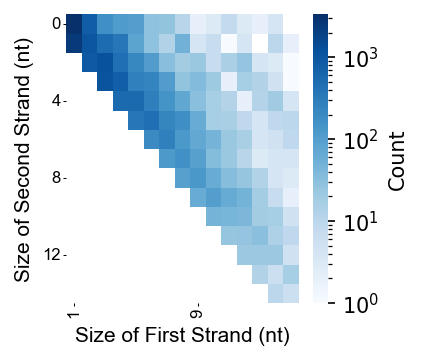

In [138]:
# Get TWOWAY motifs and split their sizes
twoways = df_unique.query("mtype == 'TWOWAY'").copy()
# Split the sequences into two parts and get lengths
twoways["size1"] = twoways["msize"].str.split("-").str[0].astype(int)
twoways["size2"] = twoways["msize"].str.split("-").str[1].astype(int)


# Create cross tabulation of the two sizes
size_matrix = pd.crosstab(twoways["size1"], twoways["size2"])

# Create heatmap
fig, ax = plt.subplots(figsize=(2.5, 2.5), dpi=150)
sns.heatmap(size_matrix.T, cmap="Blues", ax=ax, cbar_kws={"label": "Count"}, norm="log")
ax.set_ylabel("Size of Second Strand (nt)")
ax.set_xlabel("Size of First Strand (nt)")
ax.set_ylim([15, 0])  # Reversed to match heatmap orientation
ax.set_xlim([0, 15])
publication_style_ax(ax)

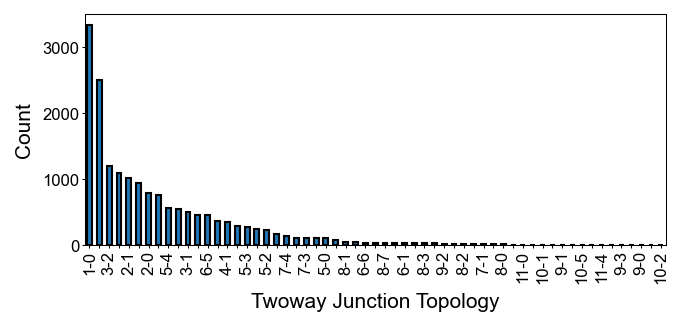

In [ ]:
# Get TWOWAY motifs and their sizes
twoways = df_unique.query("mtype == 'TWOWAY'").copy()
twoways = add_residue_count(twoways)
twoways = twoways.query("residue_num <= 15")
twoway_sizes = twoways["msize"].value_counts()

# Create bar plot of twoway sizes
fig, ax = plt.subplots(figsize=(5.0, 2.0), dpi=150)
twoway_sizes.plot(kind="bar", ax=ax, edgecolor="black")
ax.set_xlabel("Twoway Junction Topology")

# Label every other bar
labels = [str(x) if i % 2 == 0 else "" for i, x in enumerate(twoway_sizes.index)]
ax.set_xticklabels(labels, rotation=90)

ax.set_ylabel("Count")
publication_style_ax(ax)

In [129]:
twoways = df_unique.query("mtype == 'TWOWAY'").copy()
twoways["size1"] = twoways["msize"].str.split("-").str[0].astype(int)
twoways["size2"] = twoways["msize"].str.split("-").str[1].astype(int)

In [137]:
sorted_twoways = twoways.sort_values(by="size1", ascending=False)
print(sorted_twoways[["msequence", "size1", "size2", "pdb_id"]].head(20))

                                                msequence  size1  size2 pdb_id
64871   UGUGACGCCUGCCCGGUGCCGGAAGGUCAAGUGGAGCGGUGCAAGC...    152     28   1JZX
90672   ACUGAACAUUGAGCCUUGAUGUGUAGGAUAGGUGGGAGGCUUUGAA...    115     10   8E35
90706   CUGAACAUUGAGCCUUGAUGUGUAGGAUAGGUGGGAGGCUUUGAAG...    114      9   8E48
85056   UGAAUCAAAGAAGGUAAUAAUCCUGUAGUCGAAAAUGUUGUCUCUC...    112     74   6SJ6
114840  UAUAAACGACAAUGGAUGUGAUGCCAAUGUAAUUUGUAACAUAGUA...    106     27   6XU8
35325   GCGCAACCCUUAAGCUUAGUUGCCAUCAUUAAGUUGGGCACUCUAA...    101     20   7ASO
72745   CGCAACCCUUAUCCUUUGUUGCCAGCGGUCCGGCCGGGAACUCAAA...     95     10   6OGI
41244   CGCAACCCCCGCCGUUAGUUGCCAGCGGUUCGGCCGGGCACUCUAA...     89      8   4V7X
41261   CGCAACCCCCGCCGUUAGUUGCCAGCGGUUCGGCCGGGCACUCUAA...     88      7   4V7Z
65136   UUGGUACGCUCAAGGGCGAUCGGGUCAGAAAAUCUACCGGUCACAU...     81      1   2O44
41275   GCCUUGACAUGCUAGGGAACCCGGGUGAAAGCCUGGGGUGCCCCGC...     74     14   4V5A
64606   GUGACCGAUAGCGCAUAGUACCGUGAGGGAAAGGUGAAAAGAAC

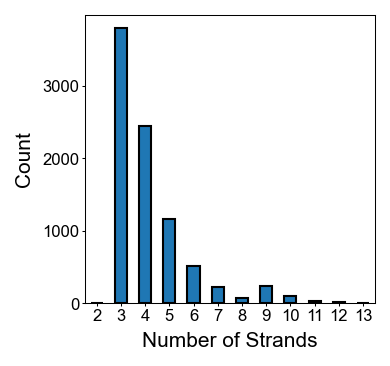

In [141]:
# Get NWAY motifs and count number of strands
nways = df_unique.query("mtype == 'NWAY'").copy()
# Count number of strands by counting "-" in sequence and adding 1
nways["num_strands"] = nways["msequence"].str.count("-") + 1
strand_counts = nways["num_strands"].value_counts().sort_index()

# Create bar plot of number of strands
fig, ax = plt.subplots(figsize=(2.5, 2.5), dpi=150)
strand_counts.plot(kind="bar", ax=ax, edgecolor="black")
ax.set_xlabel("Number of Strands")

# Label every bar since there will be fewer bars
ax.set_xticklabels([str(x) for x in strand_counts.index], rotation=0)

ax.set_ylabel("Count")
publication_style_ax(ax)